# Metric learning

*Selected Topics in Mathematical Optimization*

**Bac Nguyen Cong** ([email](bac.nguyencong@ugent.be))

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from collections import Counter
from scipy.spatial.distance import mahalanobis


from solution import NCA

## 1. Exercise
Implement a function that returns the objective function value and the corresponding gradient for NCA

In [2]:
class MyModel(NCA):
    r"""Neighborhood Components Analysis(NCA).

    NCA is a distance metric learning algorithm which aims to improve the
    accuracy of nearest neighbors classification compared to the standard
    Euclidean distance. The algorithm directly maximizes a stochastic variant
    of the leave-one-out k-nearest neighbors(KNN) score on the training set.
    It can also learn a low-dimensional linear transformation of data that can
    be used for data visualization and fast classification.

    """    
    def compute_gradient(self, A, X, y):
        """Compute the objective function value and gradients.

        Args:
            A (array-like, shape=[n_features * n_projected]):
                The linear transformation matrix.
            X (array-like, shape=[n_examples, n_features]): Training data.
            y (array-like, shape=[n_examples]): Class labels
                for each data sample.

        Returns:
            value (float): The objective function value.
            grads (array-like, shape=[n_features * n_projected]): The
                gradients.

        """
        pass

### Helper functions

In [5]:
def load_data():
    data = load_wine()
    X, y = data.data, data.target
    return X, y


def get_pipeline(ml_model):
    """Build a pipeline for testing the ml_model."""
    pipeline = Pipeline([
        ('Feature', ml_model),
        ('Classifer', KNeighborsClassifier(n_neighbors=3))
    ])
    return pipeline


def score_solution(ml_model):
    # load data
    X, y = load_data()
    
    # build the pipeline
    model = get_pipeline(ml_model)
    
    # compute cross validation
    cv = StratifiedKFold(n_splits=10, random_state=123456789)
    scores = cross_val_score(model, X, y, cv=cv)
    print('Accuracy %2.2f%c' % (scores.mean()*100, '%'))
    
    return scores


def visualize(ml_model):
    X, y = load_data()
    
    # visualize the data in 2D
    X_embedded = ml_model.fit_transform(X, y)
    data_map = pd.DataFrame({'x': X_embedded[:, 0], 'y': X_embedded[:, 1], 'Class': y})
    sns.scatterplot(x="x", y="y", hue="Class", data=data_map)

    plt.show()

## 2. Test your solution

Print the accuracy

In [6]:
nca_model = NCA(n_components=2, verbose=False)
score = score_solution(nca_model)

Accuracy 97.21%


Compare the result using PCA

In [7]:
pca_model = PCA(n_components=2)
score = score_solution(pca_model)

Accuracy 70.46%


Visualize the outputs

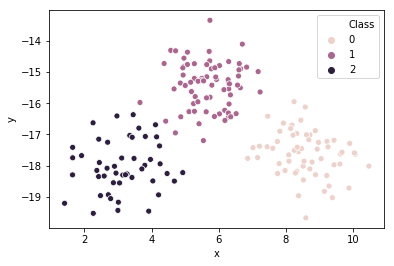

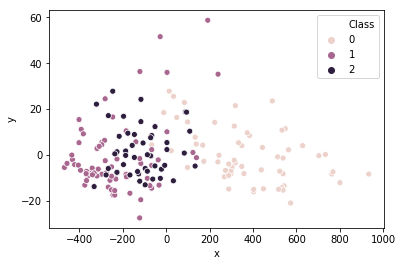

In [8]:
nca_model = NCA(n_components=2)
pca_model = PCA(n_components=2)

visualize(nca_model)
visualize(pca_model)

## 3. Recipe dataset

We will illustrate metric learning on the [recipes dataset](https://www.nature.com/articles/srep00196). This is a collection of recipes (set of ingredients used) annotated with the country of origin. We will build a distance function to measure if two collections of recipes likely have a similar country of origin or not.

For an illustration of a machine learning project using this data, see our [paper](https://www.sciencedirect.com/science/article/abs/pii/S0924224415002873).

In [10]:
recipes = pd.read_csv("recipe_data.csv", sep=';')
recipes.head()

,Country,almond,basil,bay,bean,beef,bell_pepper,black_pepper,bread,butter,...,shrimp,soy_sauce,tomato,turmeric,vanilla,vegetable_oil,vinegar,wheat,yeast,yogurt
2,African,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,1,0,0,1
3,African,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,African,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,African,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,African,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


Let us separate the ingredients.

In [65]:
ingredients = recipes.columns[1:]

X = recipes.values[:,1:]
X = np.array(X, dtype=int)

for ingredient in ingredients:
    print(ingredient)

almond
basil
bay
bean
beef
bell_pepper
black_pepper
bread
butter
cane_molasse
cardamom
carrot
cayenne
chicken
chicken_broth
chickpea
cilantro
cinnamon
coconut
coriander
cream
cucumber
cumin
dill
egg
fenugreek
fish
garlic
ginger
honey
lamb
lemon
lemon_juice
lemongrass
lime
lime_juice
milk
mint
mustard
olive_oil
onion
parsley
pepper
potato
raisin
rice
scallion
seed
shallot
shrimp
soy_sauce
tomato
turmeric
vanilla
vegetable_oil
vinegar
wheat
yeast
yogurt


We define two useful functions:

- `ingr2vec` maps a set of ingredients to a binary vector
- `vec2ingr` maps a binary vector to a set of ingedients

In [34]:
ingr2vec = lambda ingr_set : np.array([1 if ingr in ingr_set else 0 for ingr in ingredients])
vec2ingr = lambda vec : set(ingredients[vec>0])

In [35]:
v = ingr2vec(("coriander", "fish", "garlic"))
v

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [36]:
vec2ingr(v)

{'coriander', 'fish', 'garlic'}

We also separate the countries!

In [16]:
countries = recipes["Country"]
Counter(countries)

Counter({'African': 281,
         'EasternEuropean': 207,
         'MiddleEastern': 361,
         'NorthernEuropean': 91,
         'SouthAsian': 472,
         'SoutheastAsian': 371})

Now fit the model!

In [78]:
nca = NCA(n_components=...)
nca.fit(...)

NCA(max_iter=1000, n_components=5, verbose=False)

In [41]:
M = pd.DataFrame(nca.return_M(), index=ingredients, columns=ingredients)
M

,almond,basil,bay,bean,beef,bell_pepper,black_pepper,bread,butter,cane_molasse,...,shrimp,soy_sauce,tomato,turmeric,vanilla,vegetable_oil,vinegar,wheat,yeast,yogurt
almond,1.539757,-0.151503,0.172674,-0.158173,0.156388,0.133075,-0.017890,0.035788,-0.220647,0.006269,...,0.051694,-0.073551,0.136490,-0.180263,0.224440,-0.188566,0.168572,-0.111405,0.449078,-0.215487
basil,-0.151503,0.950450,-0.027159,0.012333,0.049638,0.013418,0.025686,0.052522,-0.082113,-0.187588,...,0.266437,0.203642,-0.099554,0.071877,0.204934,0.009606,0.093836,-0.014075,-0.022965,-0.089173
bay,0.172674,-0.027159,0.802466,-0.021782,-0.080288,-0.000493,-0.089225,0.185506,0.096625,0.217534,...,-0.203770,0.053823,0.018215,-0.004439,0.154743,-0.059873,0.048756,-0.103027,0.220325,0.046039
bean,-0.158173,0.012333,-0.021782,0.848028,-0.040500,-0.092948,-0.028660,-0.028282,0.082584,0.171098,...,0.010862,0.133503,-0.124215,-0.060966,0.090048,0.046298,-0.045447,-0.048010,0.001728,-0.015366
beef,0.156388,0.049638,-0.080288,-0.040500,1.172463,0.030186,-0.031878,0.112089,0.038370,0.037244,...,0.456600,0.167344,-0.022421,-0.081627,0.119249,-0.017621,0.006434,0.031311,0.271899,-0.092958
bell_pepper,0.133075,0.013418,-0.000493,-0.092948,0.030186,0.855588,0.045391,0.045642,0.032031,-0.102409,...,-0.056541,-0.052064,0.048591,-0.021617,0.100373,0.030606,-0.045354,-0.009557,0.202789,-0.020169
black_pepper,-0.017890,0.025686,-0.089225,-0.028660,-0.031878,0.045391,0.887552,-0.011326,-0.029009,0.044301,...,-0.061599,-0.201964,0.010136,-0.006912,0.362708,-0.008872,-0.007742,-0.045971,0.087173,0.067170
bread,0.035788,0.052522,0.185506,-0.028282,0.112089,0.045642,-0.011326,1.177124,-0.106587,0.209228,...,-0.089933,0.093368,-0.067676,0.122323,0.206458,-0.125472,-0.118483,0.139406,0.079448,-0.184312
butter,-0.220647,-0.082113,0.096625,0.082584,0.038370,0.032031,-0.029009,-0.106587,0.935720,0.129490,...,0.152081,-0.152442,0.026634,-0.133326,-0.214794,0.245756,-0.017516,-0.152833,-0.209049,-0.073051
cane_molasse,0.006269,-0.187588,0.217534,0.171098,0.037244,-0.102409,0.044301,0.209228,0.129490,1.222460,...,0.117755,-0.086387,0.002809,0.115268,-0.172582,0.012991,-0.303536,0.026831,0.172561,0.105693


In [79]:
L = pd.DataFrame(nca.return_L(), index=ingredients)
L

,0,1,2,3,4
almond,-0.363498,-0.482919,0.597695,0.024041,-0.456479
basil,0.147617,-0.467791,0.097198,-0.152690,0.812261
bay,-0.029175,0.305595,-0.140517,-0.358542,0.006367
bean,0.629863,0.690818,-0.143950,-0.165969,-0.168031
beef,0.395012,-0.848694,-0.845834,-0.278934,-0.046194
bell_pepper,-0.300749,-0.420414,-0.224661,-0.603074,0.518616
black_pepper,-0.385575,0.229225,-0.297497,-0.169379,-0.121636
bread,0.687456,-0.296148,-0.871185,0.020580,-0.149171
butter,-0.036697,0.279037,0.002216,-0.687401,-0.200924
cane_molasse,0.204657,0.840674,-0.369011,-0.016584,-0.034077


In [83]:
recipedist = lambda recipe1, recipe2 : mahalanobis(ingr2vec(recipe1), ingr2vec(recipe2), M)

In [81]:
recipedist(("fish", "musterd", "shallot"), ("chicken", "musterd", "vinegar"))

1.8368480511969485

In [82]:
recipedist(("fish", "musterd", "shallot"), ("chicken", "coconut", "coriander"))

2.0541967749215106

In [84]:
recipedist(("fish", "musterd", "shallot"), ("vanilla", "coconut", "cream"))

2.3774004733336924

**Assignments**

1. Fit an NCA model to the recipes data.
2. Perform an interpretation of $L$ and $M$, which ingredients are (dis)similar?
3. Make a biplot of the ingredients and make a scatter plot of the recipes based on the learned space.
4. Find two recipes which differ with only one ingredient, but have an *as large as possible* Mahalanobis distance between them.
5. Find two recipes which differ with *two* ingredient, but have an *as small as possible* Mahalanobis distance between them.